# Training Data

## Model Development

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

In [71]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [82]:
df = pd.read_csv("../data/processed_hcvdat.csv")

In [83]:
df.head()

,Unnamed: 0,Age,Sex,ALB,ALP,AST,BIL,CHE,CHOL,CREA,CGT,PROT,ALT,Category
0,0,32,1,38.5,52.5,22.1,7.5,6.93,3.23,106.0,12.1,69.0,7.7,0
1,1,32,1,38.5,70.3,24.7,3.9,11.17,4.80,74.0,15.6,76.5,18.0,0
2,2,32,1,46.9,74.7,52.6,6.1,8.84,5.20,86.0,33.2,79.3,36.2,0
3,3,32,1,43.2,52.0,22.6,18.9,7.33,4.74,80.0,33.8,75.7,30.6,0
4,4,32,1,39.2,74.1,24.8,9.6,9.15,4.32,76.0,29.9,68.7,32.6,0


In [84]:
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Age,Sex,ALB,ALP,AST,BIL,CHE,CHOL,CREA,CGT,PROT,ALT,Category
0,32,1,38.5,52.5,22.1,7.5,6.93,3.23,106.0,12.1,69.0,7.7,0
1,32,1,38.5,70.3,24.7,3.9,11.17,4.80,74.0,15.6,76.5,18.0,0
2,32,1,46.9,74.7,52.6,6.1,8.84,5.20,86.0,33.2,79.3,36.2,0
3,32,1,43.2,52.0,22.6,18.9,7.33,4.74,80.0,33.8,75.7,30.6,0
4,32,1,39.2,74.1,24.8,9.6,9.15,4.32,76.0,29.9,68.7,32.6,0


In [85]:
y = df['Category']
X = df.iloc[:, :-1]

In [86]:
# train-test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [87]:
# normalize dataset
def normalize_columns(features):
    return (features - features.mean()) / features.std()

In [88]:
X_train.iloc[:, X_train.columns!='Sex'] = normalize_columns(X_train.iloc[:, X_train.columns!='Sex'])

In [89]:
X_train.head()

,Age,Sex,ALB,ALP,AST,BIL,CHE,CHOL,CREA,CGT,PROT,ALT
296,1.675426,1,0.483197,0.957839,-0.332392,0.051932,0.647577,2.013413,-0.072836,-0.375485,0.444943,-0.542276
554,-0.355107,1,1.255722,-1.872614,-0.116665,0.088394,0.375705,-1.175628,-0.012840,-0.198928,0.167230,0.493927
443,0.152526,0,-1.164856,-1.376700,-0.436159,-0.218932,-1.316465,0.414500,0.012872,-0.656581,-1.739728,-0.534019
301,1.776953,1,-0.443832,-1.007104,-0.214971,-0.255395,-0.519598,0.721983,-0.158544,-0.210544,-1.406473,-0.212012
247,0.761686,1,1.015381,0.213968,-0.296893,-0.286648,0.530390,-0.683655,0.012872,-0.164082,0.889282,-0.100548


In [90]:
X_test.iloc[:, X_test.columns!='Sex'] = normalize_columns(X_test.iloc[:, X_test.columns!='Sex'])
X_test.head()

,Age,Sex,ALB,ALP,AST,BIL,CHE,CHOL,CREA,CGT,PROT,ALT
248,0.739916,1,-2.356918,-0.143405,-0.695268,-0.424021,-1.196326,-0.811931,-0.786594,-0.283817,-1.852933,-0.437562
365,-0.777860,0,-1.775204,1.064944,-0.717098,-0.443262,-1.039445,0.026495,-0.618680,-0.328066,-0.016246,-0.437562
432,0.075889,0,0.393002,-0.602876,-0.311053,-0.169067,-0.106642,0.100203,-0.842565,-0.455449,0.132173,-0.412704
610,1.403943,0,-1.669438,10.331936,3.356450,1.846506,-1.200566,0.947842,-1.307127,8.092654,-0.721237,-0.817538
132,-0.303555,1,-1.052469,0.339934,-0.171339,-0.250845,0.173199,1.270314,0.220890,-0.311975,-0.813999,-0.050484


In [108]:
# the general function for model training
# input: model, training sets, testing sets, model name
def model_training(model, X_train, y_train, X_test, y_test, model_name):
    print(f"Train data using {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # validate via accuracy score and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print("The classification report is as follows:")
    print(report)
    print()
    print(f"The accuracy score of this model is {accuracy:.4f}")
    # validate via roc curve and auc
    # fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    normal_auc = roc_auc_score(y_test, y_pred)
    print(f"The AUC score of this model is {normal_auc: .4f}")

    y_score = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    pr_auc = auc(recall, precision)
    print(f"The PR AUC score of this model is {pr_auc: .4f}")
    print()
    print("The confusion matrix on testing data is as follows:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # return the trained model
    return model, cm

In [46]:
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

In [91]:
# Hyperparameter grids
logistic_params = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6]
}

In [92]:
# Models
models = {
    'Logistic Regression': LogisticRegression(solver = 'liblinear'),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier()
}

# Hyperparameter grids
param_grids = {
    'Logistic Regression': logistic_params,
    'Random Forest': rf_params,
    'XGBoost': xgb_params
}

In [94]:
# use 5-fold validation for hyperparameter tuning
# finally predict on test set
best_params = {}
for name, model in models.items():
    # this phase selects the best hyperparameters for each model
    grid_search = GridSearchCV(model, param_grids[name], cv = 5, scoring='roc_auc', verbose=1, n_jobs=-1)
    total_fits = len(grid_search.param_grid) * grid_search.cv
    for params in tqdm(grid_search.param_grid, total=total_fits):
        grid_search.fit(X_train, y_train)
    best_params[name] = grid_search.best_params_

    # Train model with best parameters on the combined training and validation set
    best_model = models[name].set_params(**best_params[name])
    best_model.fit(X_train, y_train)

    # Predict on test set
    # this phase evaluates the best model on the test set
    predictions = best_model.predict(X_test)


    # Compute accuracy
    acc = accuracy_score(y_test, predictions)
    print(f"{name} - Best Parameters: {best_params[name]}")
    print(f"{name} - Test Accuracy: {acc:.4f}")

 20%|██        | 2/10 [00:00<00:00, 24.99it/s]


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Logistic Regression - Best Parameters: {'C': 0.1, 'penalty': 'l1'}
Logistic Regression - Test Accuracy: 0.8973


  0%|          | 0/15 [00:00<?, ?it/s]

Fitting 5 folds for each of 36 candidates, totalling 180 fits


  7%|▋         | 1/15 [00:02<00:30,  2.15s/it]

Fitting 5 folds for each of 36 candidates, totalling 180 fits


 13%|█▎        | 2/15 [00:04<00:27,  2.08s/it]

Fitting 5 folds for each of 36 candidates, totalling 180 fits


 20%|██        | 3/15 [00:06<00:25,  2.13s/it]


Random Forest - Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest - Test Accuracy: 0.9514


  0%|          | 0/15 [00:00<?, ?it/s]

Fitting 5 folds for each of 36 candidates, totalling 180 fits


  7%|▋         | 1/15 [00:00<00:09,  1.46it/s]

Fitting 5 folds for each of 36 candidates, totalling 180 fits


 13%|█▎        | 2/15 [00:01<00:08,  1.62it/s]

Fitting 5 folds for each of 36 candidates, totalling 180 fits


 20%|██        | 3/15 [00:01<00:07,  1.66it/s]

XGBoost - Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
XGBoost - Test Accuracy: 0.9730


In [95]:
# best parameters
logistic_params_best = {'C': 1, 'penalty': 'l1'}

rf_params_best = {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

xgb_params_best = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

In [109]:
# logistic regression
model_logreg = LogisticRegression(solver='liblinear')
model_logreg.set_params(**logistic_params_best)
model_name = "Logistic Regression"
model_logreg, cm_logreg = model_training(model_logreg, X_train, y_train, X_test, y_test, model_name)

Train data using Logistic Regression...
The classification report is as follows:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       156
           1       0.75      0.41      0.53        29

    accuracy                           0.89       185
   macro avg       0.82      0.69      0.73       185
weighted avg       0.88      0.89      0.87       185


The accuracy score of this model is 0.8865
The AUC score of this model is  0.6941
The PR AUC score of this model is  0.7520

The confusion matrix on testing data is as follows:
[[152   4]
 [ 17  12]]


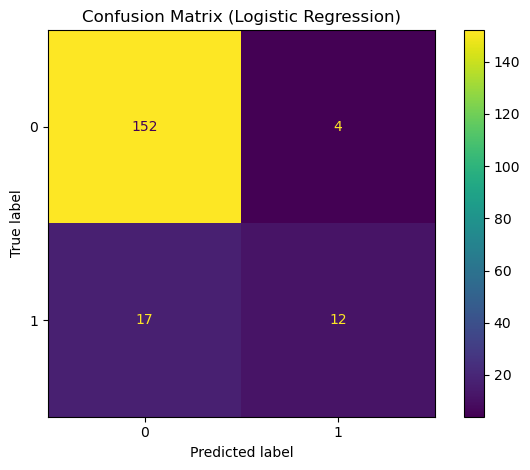

In [105]:
cmd_logreg = ConfusionMatrixDisplay(cm_logreg)
cmd_logreg.plot()
plt.title('Confusion Matrix (Logistic Regression)')
plt.tight_layout()
plt.savefig('../figures/cmd_reg.jpg')

In [110]:
# XGBoost
model_xgb = xgb.XGBClassifier()
model_xgb.set_params(**xgb_params_best)
model_name = "XGBoost"
model_xgb, cm_xgb = model_training(model_xgb, X_train, y_train, X_test, y_test, model_name)

Train data using XGBoost...
The classification report is as follows:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       156
           1       0.96      0.86      0.91        29

    accuracy                           0.97       185
   macro avg       0.97      0.93      0.95       185
weighted avg       0.97      0.97      0.97       185


The accuracy score of this model is 0.9730
The AUC score of this model is  0.9278
The PR AUC score of this model is  0.9627

The confusion matrix on testing data is as follows:
[[155   1]
 [  4  25]]


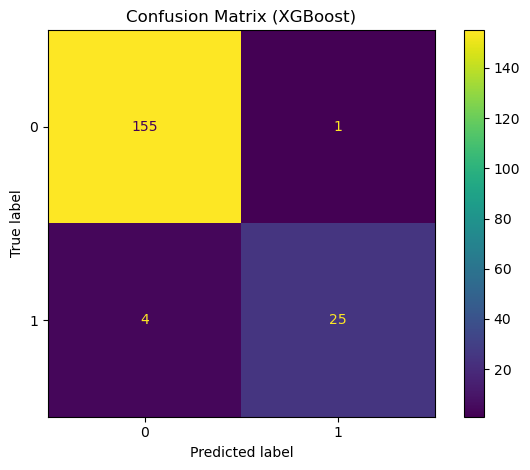

In [106]:
cmd_xgb = ConfusionMatrixDisplay(cm_xgb)
cmd_xgb.plot()
plt.title('Confusion Matrix (XGBoost)')
plt.tight_layout()
plt.savefig('../figures/cmd_xgb.jpg')

In [111]:
# random forest
model_rf = RandomForestClassifier()
model_rf.set_params(**rf_params_best)
model_name = "Random Forest"
model_rf, cm_rf = model_training(model_rf, X_train, y_train, X_test, y_test, model_name)

Train data using Random Forest...
The classification report is as follows:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       156
           1       0.90      0.66      0.76        29

    accuracy                           0.94       185
   macro avg       0.92      0.82      0.86       185
weighted avg       0.93      0.94      0.93       185


The accuracy score of this model is 0.9351
The AUC score of this model is  0.8212
The PR AUC score of this model is  0.8981

The confusion matrix on testing data is as follows:
[[154   2]
 [ 10  19]]


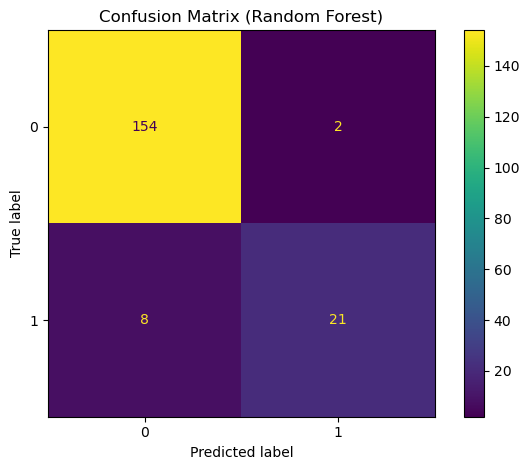

In [107]:
cmd_rf = ConfusionMatrixDisplay(cm_rf)
cmd_rf.plot()
plt.title('Confusion Matrix (Random Forest)')
plt.tight_layout()
plt.savefig('../figures/cmd_rf.jpg')

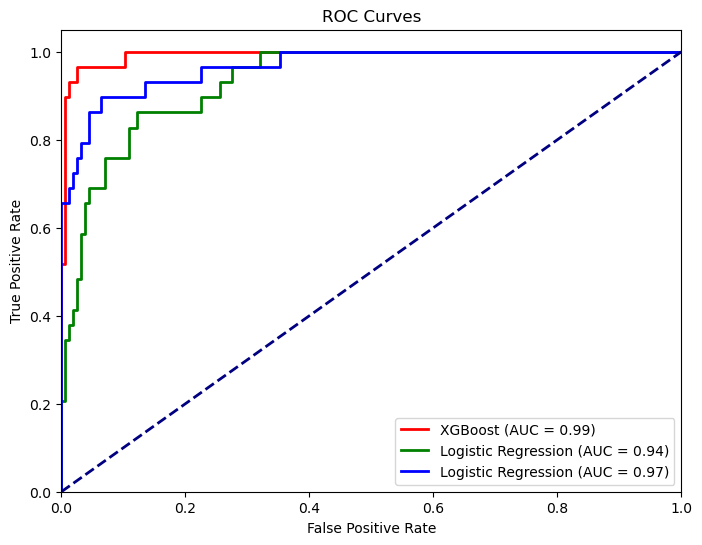

In [112]:
# plot out ROC curve
y_prob_xgb = model_xgb.predict_proba(X_test)[:, 1]
y_prob_reg = model_logreg.predict_proba(X_test)[:, 1]
y_prob_rf = model_rf.predict_proba(X_test)[:, 1]

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
fpr_reg, tpr_reg, _ = roc_curve(y_test, y_prob_reg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_reg = auc(fpr_reg, tpr_reg)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_reg, tpr_reg, color='green', lw=2, label=f'Logistic Regression (AUC = {roc_auc_reg:.2f})')
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_rf:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.tight_layout
plt.savefig("../figures/roc_curves.jpg")